# Part #02: Preprocessing for Machine Learning

## Step #01: Exploratory Data Analysis Revisited

### Set up the workspace

In [1]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, RobustScaler

### Gather (or read) the data

In [2]:
cal_housing_prices = pd.read_csv("./datasets/housing.csv")

### Explore the first few rows

In [3]:
cal_housing_prices.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Specify columns by data type

In [4]:
target_col = "median_house_value"
target_col

'median_house_value'

In [5]:
cat_cols = cal_housing_prices.select_dtypes(exclude="number").columns.tolist()
cat_cols

['ocean_proximity']

In [6]:
num_cols = [c for c in cal_housing_prices.columns if c not in [*cat_cols, target_col]]
num_cols

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

### Check for missing values

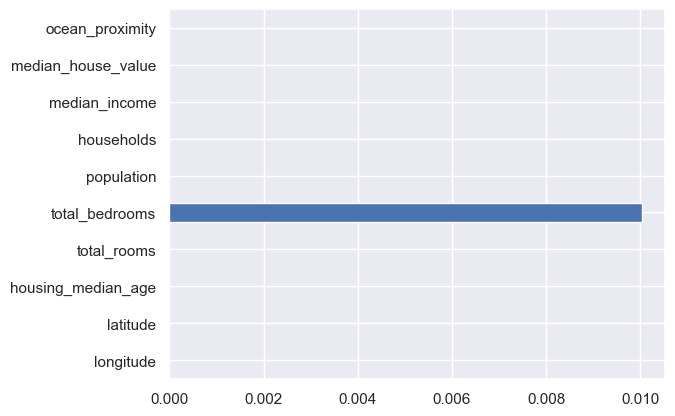

In [7]:
cal_housing_prices.isna().mean().plot.barh();

### Check for non-numerical features

In [8]:
cal_housing_prices[cat_cols].value_counts(normalize=True).round(4) * 100

ocean_proximity
<1H OCEAN          44.26
INLAND             31.74
NEAR OCEAN         12.88
NEAR BAY           11.09
ISLAND              0.02
Name: proportion, dtype: float64

### Check for distribution and outliers in numerical featues

In [9]:
cal_housing_prices.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


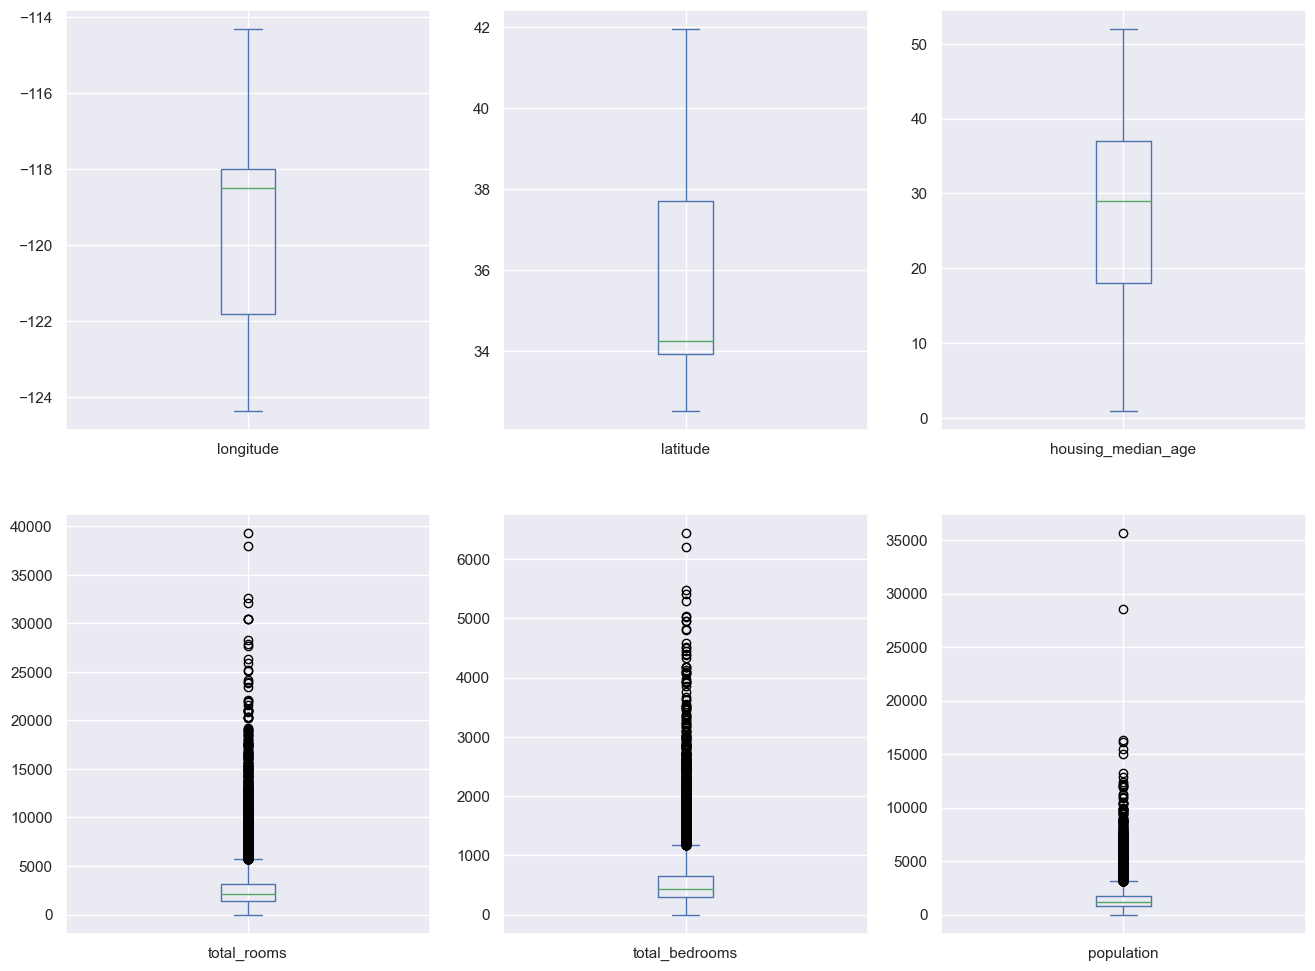

In [10]:
# Plot the distrubution of all numerical columns using boxplot (except the target):
fig, axs = plt.subplots(2, 3, figsize=(16, 12))
axs = axs.flatten()
for col, ax in zip(num_cols, axs):
    cal_housing_prices[col].plot.box(ax=ax)

### Create a custom transformer to clean the data all at once

In [11]:
# 1. Create a function to drop irrelevant features and low-frequency categories:
def clean_data(data, drop_cols=None, masks=None, drop_na=False):
    """Drops irrelevant features and low-frequency categories."""
    data_copy = data.copy()
    if drop_cols is not None:
        data_copy = data_copy.drop(drop_cols, axis=1)
    if masks is not None:
        for col, mask in masks.items():
            data_copy = data_copy[eval(f"data_copy['{col}'] {mask}")].copy()
    if drop_na is True:
        data_copy.dropna(inplace=True)
    return data_copy

# 2. Create a kw_args dictionary:
kw_args = {
    "drop_cols": ["total_bedrooms", "households"],
    "masks": {"ocean_proximity": "!= 'ISLAND'"},
    "drop_na": True
}

# 3. Create the custom transformer:
cleaner = FunctionTransformer(
    func=clean_data,
    feature_names_out="one-to-one",
    kw_args=kw_args
)

In [12]:
cal_housing_prices_clean = cleaner.fit_transform(cal_housing_prices)

In [13]:
cal_housing_prices_clean.head()

,longitude,latitude,housing_median_age,total_rooms,population,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,322.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,2401.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,496.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,558.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,565.0,3.8462,342200.0,NEAR BAY


In [14]:
cal_housing_prices_clean.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,20635.0,-119.569999,2.003685,-124.3500,-121.8000,-118.5000,-118.0100,-114.3100
latitude,20635.0,35.632412,2.135918,32.5400,33.9300,34.2600,37.7100,41.9500
housing_median_age,20635.0,28.636152,12.583924,1.0000,18.0000,29.0000,37.0000,52.0000
total_rooms,20635.0,2636.020208,2181.794772,2.0000,1448.0000,2127.0000,3148.0000,39320.0000
population,20635.0,1425.660286,1132.530137,3.0000,787.0000,1166.0000,1725.0000,35682.0000
median_income,20635.0,3.870944,1.899961,0.4999,2.5631,3.5352,4.7437,15.0001
median_house_value,20635.0,206813.756288,115372.499511,14999.0000,119600.0000,179700.0000,264700.0000,500001.0000


## Step #02: Splitting the Data into Training and Testing Sets

In [15]:
# Split the data into feature matrix and target vector:
X = cal_housing_prices_clean.drop(target_col, axis=1)
y = cal_housing_prices_clean[target_col]

In [16]:
# Split the data into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step #03: Chaining the Steps of Data Preprocessing into a Pipeline 

In [17]:
# Create a custom log-transformer:

# 1. Create a function to perform log-transformation:
def perform_log_trans(X, transform_cols=None):
    """Performs log transformation."""
    X_copy = X.copy()
    cols = transform_cols or X.select_dtypes(include="number").columns.tolist()
    X_copy[cols] = X_copy[cols].applymap(lambda x: np.log(abs(x)))
    return X_copy

# 2. Create a kw_args dictionary:
kw_args = {
    "transform_cols": ["longitude", "latitude", "total_rooms", "population", "median_income"]
}

# 3. Create a custom transformer:
log_transformer = FunctionTransformer(
    func=perform_log_trans,
    feature_names_out="one-to-one"
)

In [18]:
# Create a numerical features sclaer:
robust_scaler_cols = X_train.select_dtypes(include="number").columns.tolist()
robust_scaler = RobustScaler()

In [19]:
# Create a categorical features encoder:
one_hot_encoder_cols = X_train.select_dtypes(exclude="number").columns.tolist()
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

In [20]:
# Create a column transformer:
col_transformer = make_column_transformer(
    (robust_scaler, robust_scaler_cols),
    (one_hot_encoder, one_hot_encoder_cols),
    remainder="passthrough",
    verbose_feature_names_out=True
)

In [21]:
# Create a pipeline for data preprocessing:
preprocessor = make_pipeline(log_transformer, col_transformer)

In [22]:
# Clean and fit X_test:
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

In [23]:
# Get the feature names:

# 1. Define a function to rename features:
def rename_features(raw_name):
    """Renames features."""
    feature_name = raw_name.rsplit("__", maxsplit=1)[-1]
    return feature_name.replace("<", "")
    
# 2. Rename features:
feature_names = [rename_features(c) for c in preprocessor.fit(X_train).get_feature_names_out()]
feature_names

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'population',
 'median_income',
 'ocean_proximity_1H OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN']

In [24]:
# Recreate the df for training set after preprocessing:
X_train_trans_df = pd.DataFrame(data=X_train_trans, columns=feature_names)
X_train_trans_df.head()

,longitude,latitude,housing_median_age,total_rooms,population,median_income,ocean_proximity_1H OCEAN,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.214942,0.520164,-0.321703,-0.198341,-0.118187,-0.188172,0.0,1.0,0.0,0.0
1,-0.144113,-0.124863,0.220756,-0.532922,-0.222410,0.485221,1.0,0.0,0.0,0.0
2,0.344262,0.670272,0.546675,0.135608,-0.367483,0.008750,0.0,1.0,0.0,0.0
3,-0.031968,-0.119279,0.446305,0.461755,0.100104,0.610227,1.0,0.0,0.0,0.0
4,-0.141438,-0.058064,0.220756,-0.057328,0.570442,-0.356489,1.0,0.0,0.0,0.0


In [25]:
# Explore the min, mean & max of X_train_trans_df:
X_train_trans_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,16508.0,0.282592,0.528809,-1.135860,-0.130741,0.000000e+00,0.869259,1.520433
latitude,16508.0,0.357922,0.560915,-0.483527,-0.091405,0.000000e+00,0.908595,1.912345
housing_median_age,16508.0,-0.202881,0.792041,-4.673255,-0.661892,0.000000e+00,0.338108,0.810424
total_rooms,16508.0,-0.046233,0.970068,-8.968127,-0.496233,0.000000e+00,0.503767,3.739534
population,16508.0,-0.045831,0.940820,-7.558871,-0.501976,0.000000e+00,0.498024,4.333428
median_income,16508.0,-0.025434,0.760414,-3.151579,-0.515521,-1.788798e-16,0.484479,2.328758
ocean_proximity_1H OCEAN,16508.0,0.442816,0.496734,0.000000,0.000000,0.000000e+00,1.000000,1.000000
ocean_proximity_INLAND,16508.0,0.317543,0.465535,0.000000,0.000000,0.000000e+00,1.000000,1.000000
ocean_proximity_NEAR BAY,16508.0,0.112430,0.315905,0.000000,0.000000,0.000000e+00,0.000000,1.000000
ocean_proximity_NEAR OCEAN,16508.0,0.127211,0.333219,0.000000,0.000000,0.000000e+00,0.000000,1.000000


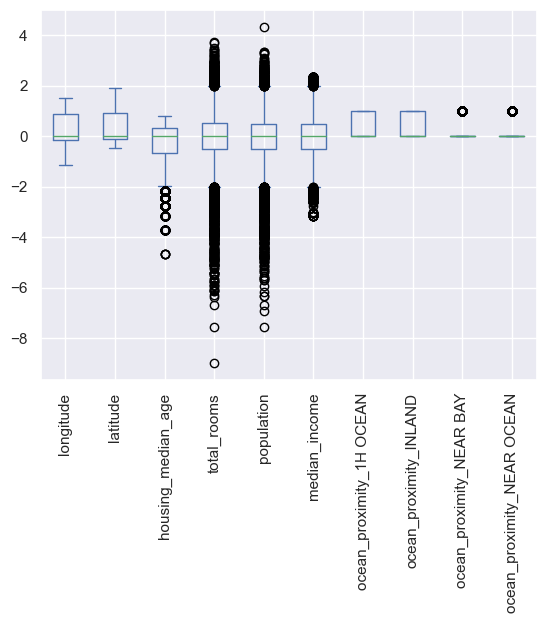

In [26]:
# Plot the distribution of X_train_trans_df:
X_train_trans_df.plot.box(rot=90);

## Step #04: Saving Results

In [27]:
# Create a dictionary to hold the results:
preprocessing_results = {
    "feature_names": feature_names,
    "X_train_trans": X_train_trans.astype(np.float32),
    "X_test_trans": X_test_trans.astype(np.float32),
    "y_train": y_train.astype(np.float32),
    "y_test": y_test.astype(np.float32)
}

In [28]:
# Pickle the results:
with open("./assets/preprocessing_results.pkl", mode="wb") as file_bin:
    pickle.dump(preprocessing_results, file_bin)